In [1]:
import pandas as pd
import os

# print(os.getcwd())
# Load the file
df = pd.read_csv("../Gen_data/actual_PV_2022-2024.csv")
# Check the first few rows
print(df.dtypes)
df.head()

datetime             object
Area                 object
Production Type      object
Generation (MWh)    float64
dtype: object


,datetime,Area,Production Type,Generation (MWh)
0,2022-01-01 00:00:00,BZN|ES,Solar,75.0
1,2022-01-01 01:00:00,BZN|ES,Solar,75.0
2,2022-01-01 02:00:00,BZN|ES,Solar,75.0
3,2022-01-01 03:00:00,BZN|ES,Solar,75.0
4,2022-01-01 04:00:00,BZN|ES,Solar,75.0


In [2]:
df = pd.read_csv("../Gen_data/actual_PV_2022-2024.csv")

# Convert datetime column to proper datetime format
df['ds'] = pd.to_datetime(df['datetime'])

# Rename the generation column for Prophet (use the MWh column name)
df['y'] = df['Generation (MWh)']

# Keep only the necessary columns
df = df[['ds', 'y']].sort_values('ds')

print(df.dtypes)
print(df.head())
print(f"\nData range: {df['ds'].min()} to {df['ds'].max()}")
print(f"Total records: {len(df)}")

ds    datetime64[ns]
y            float64
dtype: object
                   ds     y
0 2022-01-01 00:00:00  75.0
1 2022-01-01 01:00:00  75.0
2 2022-01-01 02:00:00  75.0
3 2022-01-01 03:00:00  75.0
4 2022-01-01 04:00:00  75.0

Data range: 2022-01-01 00:00:00 to 2024-12-31 23:00:00
Total records: 26301


In [3]:
# Data quality check and outlier detection
print("Data Quality Analysis:")
print("=" * 60)

# Check for missing values
missing_count = df['y'].isna().sum()
print(f"Missing values: {missing_count}")

# Check for negative values (shouldn't exist for solar generation)
negative_count = (df['y'] < 0).sum()
print(f"Negative values: {negative_count}")

# Detect outliers using IQR method
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR  # 3*IQR for extreme outliers
upper_bound = Q3 + 3 * IQR

outliers = ((df['y'] < lower_bound) | (df['y'] > upper_bound)).sum()
print(f"Outliers detected (3*IQR method): {outliers}")

# Show basic statistics
print(f"\nGeneration statistics:")
print(f"  Min: {df['y'].min():.2f} MWh")
print(f"  Max: {df['y'].max():.2f} MWh")
print(f"  Mean: {df['y'].mean():.2f} MWh")
print(f"  Median: {df['y'].median():.2f} MWh")
print(f"  Std: {df['y'].std():.2f} MWh")
print(f"  95th percentile: {df['y'].quantile(0.95):.2f} MWh")
print(f"  99th percentile: {df['y'].quantile(0.99):.2f} MWh")

# Cap extreme outliers to reasonable maximum
df_cleaned = df.copy()
max_reasonable = df['y'].quantile(0.99) * 1.1  # 110% of 99th percentile
df_cleaned.loc[df_cleaned['y'] > max_reasonable, 'y'] = max_reasonable
df_cleaned.loc[df_cleaned['y'] < 0, 'y'] = 0  # Remove any negative values

capped_count = (df['y'] != df_cleaned['y']).sum()
print(f"\nCapped {capped_count} extreme values to max: {max_reasonable:.2f} MWh")
print("Data is ready for modeling")

# Update df with cleaned data
df = df_cleaned

Data Quality Analysis:
Missing values: 0
Negative values: 0
Outliers detected (3*IQR method): 0

Generation statistics:
  Min: 0.00 MWh
  Max: 21280.00 MWh
  Mean: 4518.56 MWh
  Median: 711.00 MWh
  Std: 5639.79 MWh
  95th percentile: 15526.00 MWh
  99th percentile: 19172.00 MWh

Capped 5 extreme values to max: 21089.20 MWh
Data is ready for modeling


In [4]:
# Split data into train (70%), validation (20%), and test (10%)
total_rows = len(df)
train_size = int(0.7 * total_rows)
val_size = int(0.2 * total_rows)

train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

print(f"Total data points: {total_rows}")
print(f"\nTraining set: {len(train_df)} records")
print(f"  Period: {train_df['ds'].min()} to {train_df['ds'].max()}")
print(f"\nValidation set: {len(val_df)} records")
print(f"  Period: {val_df['ds'].min()} to {val_df['ds'].max()}")
print(f"\nTest set: {len(test_df)} records")
print(f"  Period: {test_df['ds'].min()} to {test_df['ds'].max()}")

Total data points: 26301

Training set: 18410 records
  Period: 2022-01-01 00:00:00 to 2024-02-07 03:00:00

Validation set: 5260 records
  Period: 2024-02-07 04:00:00 to 2024-09-13 08:00:00

Test set: 2631 records
  Period: 2024-09-13 09:00:00 to 2024-12-31 23:00:00


In [5]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Create and fit the model with tuned hyperparameters
model = Prophet(
    # Seasonality settings
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    
    # Regularization parameters (prevent overfitting)
    changepoint_prior_scale=0.01,   # Lower value for more stable trend
    seasonality_prior_scale=5.0,    # Reduced to prevent over-seasonality
    
    # Changepoint settings
    changepoint_range=0.8,          # Use 80% of data for detecting trend changes
    n_changepoints=15,              # Fewer changepoints for stability
    
    # Seasonality mode
    seasonality_mode='additive',    # Changed to additive (more stable than multiplicative)
    
    # Interval width
    interval_width=0.95,            # 95% confidence intervals
    
    # Growth model
    growth='linear',                # Linear growth (default)
    
    # Other settings
    mcmc_samples=0,                 # Use MAP estimation (faster)
    uncertainty_samples=1000         # Samples for uncertainty intervals
)

# Add floor constraint (solar generation cannot be negative)
train_df['floor'] = 0
model.fit(train_df)

print("Training Prophet model with optimized hyperparameters...")
print("=" * 60)
print("Model Configuration:")
print(f"  - Growth: {model.growth}")
print(f"  - Changepoint prior scale: {model.changepoint_prior_scale}")
print(f"  - Seasonality prior scale: {model.seasonality_prior_scale}")
print(f"  - Seasonality mode: {model.seasonality_mode}")
print(f"  - Floor constraint: 0 (no negative values)")
print("=" * 60)

print("\nTraining complete!")

c:\Users\Archer\Documents\Vscode\venv\p312_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
21:54:58 - cmdstanpy - INFO - Chain [1] start processing
21:55:04 - cmdstanpy - INFO - Chain [1] done processing


Training Prophet model with optimized hyperparameters...
Model Configuration:
  - Growth: linear
  - Changepoint prior scale: 0.01
  - Seasonality prior scale: 5.0
  - Seasonality mode: additive
  - Floor constraint: 0 (no negative values)

Training complete!


In [6]:
# Optional: Hyperparameter tuning with cross-validation
# This cell can take several minutes to run - uncomment to enable

"""
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

print("Starting hyperparameter tuning...")
print("This may take 5-10 minutes...")

# Define parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1],
    'seasonality_prior_scale': [1.0, 5.0, 10.0, 15.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Store results
results = []

for params in all_params[:8]:  # Test first 8 combinations (limit for speed)
    # Create model with current params
    m = Prophet(**params, 
                daily_seasonality=True, 
                weekly_seasonality=True, 
                yearly_seasonality=True)
    m.fit(train_df)
    
    # Validate on validation set
    val_pred = m.predict(val_df[['ds']])
    val_mae = mean_absolute_error(val_df['y'].values, val_pred['yhat'].values)
    
    # Store result
    results.append({**params, 'mae': val_mae})
    print(f"Tested: {params} -> MAE: {val_mae:.2f}")

# Find best parameters
best_params = min(results, key=lambda x: x['mae'])
print(f"\nBest parameters found:")
print(best_params)
"""

print("Hyperparameter tuning cell (commented out for speed)")
print("Uncomment to run full grid search")

Hyperparameter tuning cell (commented out for speed)
Uncomment to run full grid search


In [7]:
# Validate model on validation set
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict on validation data (add floor constraint)
val_df_pred = val_df.copy()
val_df_pred['floor'] = 0
val_forecast = model.predict(val_df_pred[['ds', 'floor']])

# Clip predictions to non-negative values (safety check)
val_forecast['yhat'] = val_forecast['yhat'].clip(lower=0)

# Reset indices to align properly
val_actual = val_df['y'].values
val_pred = val_forecast['yhat'].values

# Calculate validation metrics
val_mae = mean_absolute_error(val_actual, val_pred)
val_rmse = np.sqrt(mean_squared_error(val_actual, val_pred))

# Calculate MAPE excluding very small values (< 10 MWh threshold for meaningful generation)
# This filters out nighttime and very low generation periods
threshold = 10  # MWh
significant_mask = val_actual >= threshold
if significant_mask.sum() > 0:
    val_mape = np.mean(np.abs((val_actual[significant_mask] - val_pred[significant_mask]) / val_actual[significant_mask])) * 100
else:
    val_mape = np.nan

print("Validation Set Performance:")
print("=" * 50)
print(f"MAE:  {val_mae:.2f} MWh")
print(f"RMSE: {val_rmse:.2f} MWh")
if not np.isnan(val_mape):
    print(f"MAPE (generation >= {threshold} MWh): {val_mape:.2f}%")
else:
    print(f"MAPE: N/A")
    
# Show additional info
zero_count = (val_actual == 0).sum()
low_gen_count = ((val_actual > 0) & (val_actual < threshold)).sum()
print(f"\nData distribution in validation set:")
print(f"  Zero values: {zero_count} ({zero_count/len(val_actual)*100:.1f}%)")
print(f"  Low generation (0-{threshold} MWh): {low_gen_count} ({low_gen_count/len(val_actual)*100:.1f}%)")
print(f"  Significant generation (>={threshold} MWh): {significant_mask.sum()} ({significant_mask.sum()/len(val_actual)*100:.1f}%)")

# Check prediction range
print(f"\nPrediction range:")
print(f"  Min: {val_pred.min():.2f} MWh")
print(f"  Max: {val_pred.max():.2f} MWh")
print(f"  Mean: {val_pred.mean():.2f} MWh")

Validation Set Performance:
MAE:  2781.23 MWh
RMSE: 3553.39 MWh
MAPE (generation >= 10 MWh): 452.64%

Data distribution in validation set:
  Zero values: 0 (0.0%)
  Low generation (0-10 MWh): 5 (0.1%)
  Significant generation (>=10 MWh): 5255 (99.9%)

Prediction range:
  Min: 0.00 MWh
  Max: 14072.31 MWh
  Mean: 5769.04 MWh


In [8]:
# Test model on test set
test_df_pred = test_df.copy()
test_df_pred['floor'] = 0
test_forecast = model.predict(test_df_pred[['ds', 'floor']])

# Clip predictions to non-negative values (safety check)
test_forecast['yhat'] = test_forecast['yhat'].clip(lower=0)

# Reset indices to align properly
test_actual = test_df['y'].values
test_pred = test_forecast['yhat'].values

# Calculate test metrics
test_mae = mean_absolute_error(test_actual, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

# Calculate MAPE excluding very small values (< 10 MWh threshold)
threshold = 10  # MWh
significant_mask = test_actual >= threshold
if significant_mask.sum() > 0:
    test_mape = np.mean(np.abs((test_actual[significant_mask] - test_pred[significant_mask]) / test_actual[significant_mask])) * 100
else:
    test_mape = np.nan

print("Test Set Performance:")
print("=" * 50)
print(f"MAE:  {test_mae:.2f} MWh")
print(f"RMSE: {test_rmse:.2f} MWh")
if not np.isnan(test_mape):
    print(f"MAPE (generation >= {threshold} MWh): {test_mape:.2f}%")
else:
    print(f"MAPE: N/A")
    
# Show additional info
zero_count = (test_actual == 0).sum()
low_gen_count = ((test_actual > 0) & (test_actual < threshold)).sum()
print(f"\nData distribution in test set:")
print(f"  Zero values: {zero_count} ({zero_count/len(test_actual)*100:.1f}%)")
print(f"  Low generation (0-{threshold} MWh): {low_gen_count} ({low_gen_count/len(test_actual)*100:.1f}%)")
print(f"  Significant generation (>={threshold} MWh): {significant_mask.sum()} ({significant_mask.sum()/len(test_actual)*100:.1f}%)")

# Check prediction range
print(f"\nPrediction range:")
print(f"  Min: {test_pred.min():.2f} MWh")
print(f"  Max: {test_pred.max():.2f} MWh")
print(f"  Mean: {test_pred.mean():.2f} MWh")

Test Set Performance:
MAE:  1523.82 MWh
RMSE: 2293.42 MWh
MAPE (generation >= 10 MWh): 414.83%

Data distribution in test set:
  Zero values: 0 (0.0%)
  Low generation (0-10 MWh): 22 (0.8%)
  Significant generation (>=10 MWh): 2609 (99.2%)

Prediction range:
  Min: 0.00 MWh
  Max: 12641.97 MWh
  Mean: 3822.24 MWh


In [9]:
# Diagnostic: Analyze error distribution on validation set
val_df_analysis = val_df.copy()
val_df_analysis['predicted'] = val_pred
val_df_analysis['error'] = val_actual - val_pred
val_df_analysis['abs_error'] = np.abs(val_df_analysis['error'])
val_df_analysis['pct_error'] = np.where(
    val_actual >= 10, 
    np.abs(val_df_analysis['error'] / val_actual) * 100,
    np.nan
)

print("Error Analysis on Validation Set:")
print("=" * 50)
print(f"\nActual generation statistics:")
print(val_df_analysis['y'].describe())

print(f"\nPredicted generation statistics:")
print(val_df_analysis['predicted'].describe())

print(f"\nAbsolute error statistics:")
print(val_df_analysis['abs_error'].describe())

print(f"\nPercentage error statistics (excluding low generation):")
print(val_df_analysis['pct_error'].describe())

# Show some examples of high errors
print(f"\n5 Largest absolute errors:")
print(val_df_analysis.nlargest(5, 'abs_error')[['ds', 'y', 'predicted', 'error', 'pct_error']])

Error Analysis on Validation Set:

Actual generation statistics:
count     5260.000000
mean      6583.207034
std       7143.369119
min          4.000000
25%        436.750000
50%       2146.500000
75%      13519.250000
max      21089.200000
Name: y, dtype: float64

Predicted generation statistics:
count     5260.000000
mean      5769.039044
std       4420.136719
min          0.000000
25%       2263.351667
50%       3528.216964
75%      10269.847645
max      14072.306589
Name: predicted, dtype: float64

Absolute error statistics:
count    5260.000000
mean     2781.232101
std      2211.843520
min         0.015129
25%      1214.042356
50%      2241.545673
75%      3838.455646
max      9858.108045
Name: abs_error, dtype: float64

Percentage error statistics (excluding low generation):
count     5255.000000
mean       452.641279
std       1247.017993
min          0.005129
25%         30.123579
50%         57.826624
75%        364.195472
max      17023.811239
Name: pct_error, dtype: float64


In [10]:
# Create forecast for entire 2025 year
# Generate future dates from 2025-01-01 to 2025-12-31 (365 days)
future_2025 = pd.DataFrame({
    'ds': pd.date_range(start='2025-01-01', end='2025-12-31 23:00:00', freq='1H'),
    'floor': 0  # Add floor constraint
})

print(f"Forecasting for 2025...")
print(f"Period: {future_2025['ds'].min()} to {future_2025['ds'].max()}")
print(f"Total forecast points: {len(future_2025)}")

forecast_2025 = model.predict(future_2025)

# Clip to ensure no negative predictions
forecast_2025['yhat'] = forecast_2025['yhat'].clip(lower=0)
forecast_2025['yhat_lower'] = forecast_2025['yhat_lower'].clip(lower=0)
forecast_2025['yhat_upper'] = forecast_2025['yhat_upper'].clip(lower=0)

print("\nForecast complete!")
print(f"Forecast range:")
print(f"  Min: {forecast_2025['yhat'].min():.2f} MWh")
print(f"  Max: {forecast_2025['yhat'].max():.2f} MWh")
print(f"  Mean: {forecast_2025['yhat'].mean():.2f} MWh")

Forecasting for 2025...
Period: 2025-01-01 00:00:00 to 2025-12-31 23:00:00
Total forecast points: 8760

Forecast complete!
Forecast range:
  Min: 0.00 MWh
  Max: 14267.59 MWh
  Mean: 5112.75 MWh


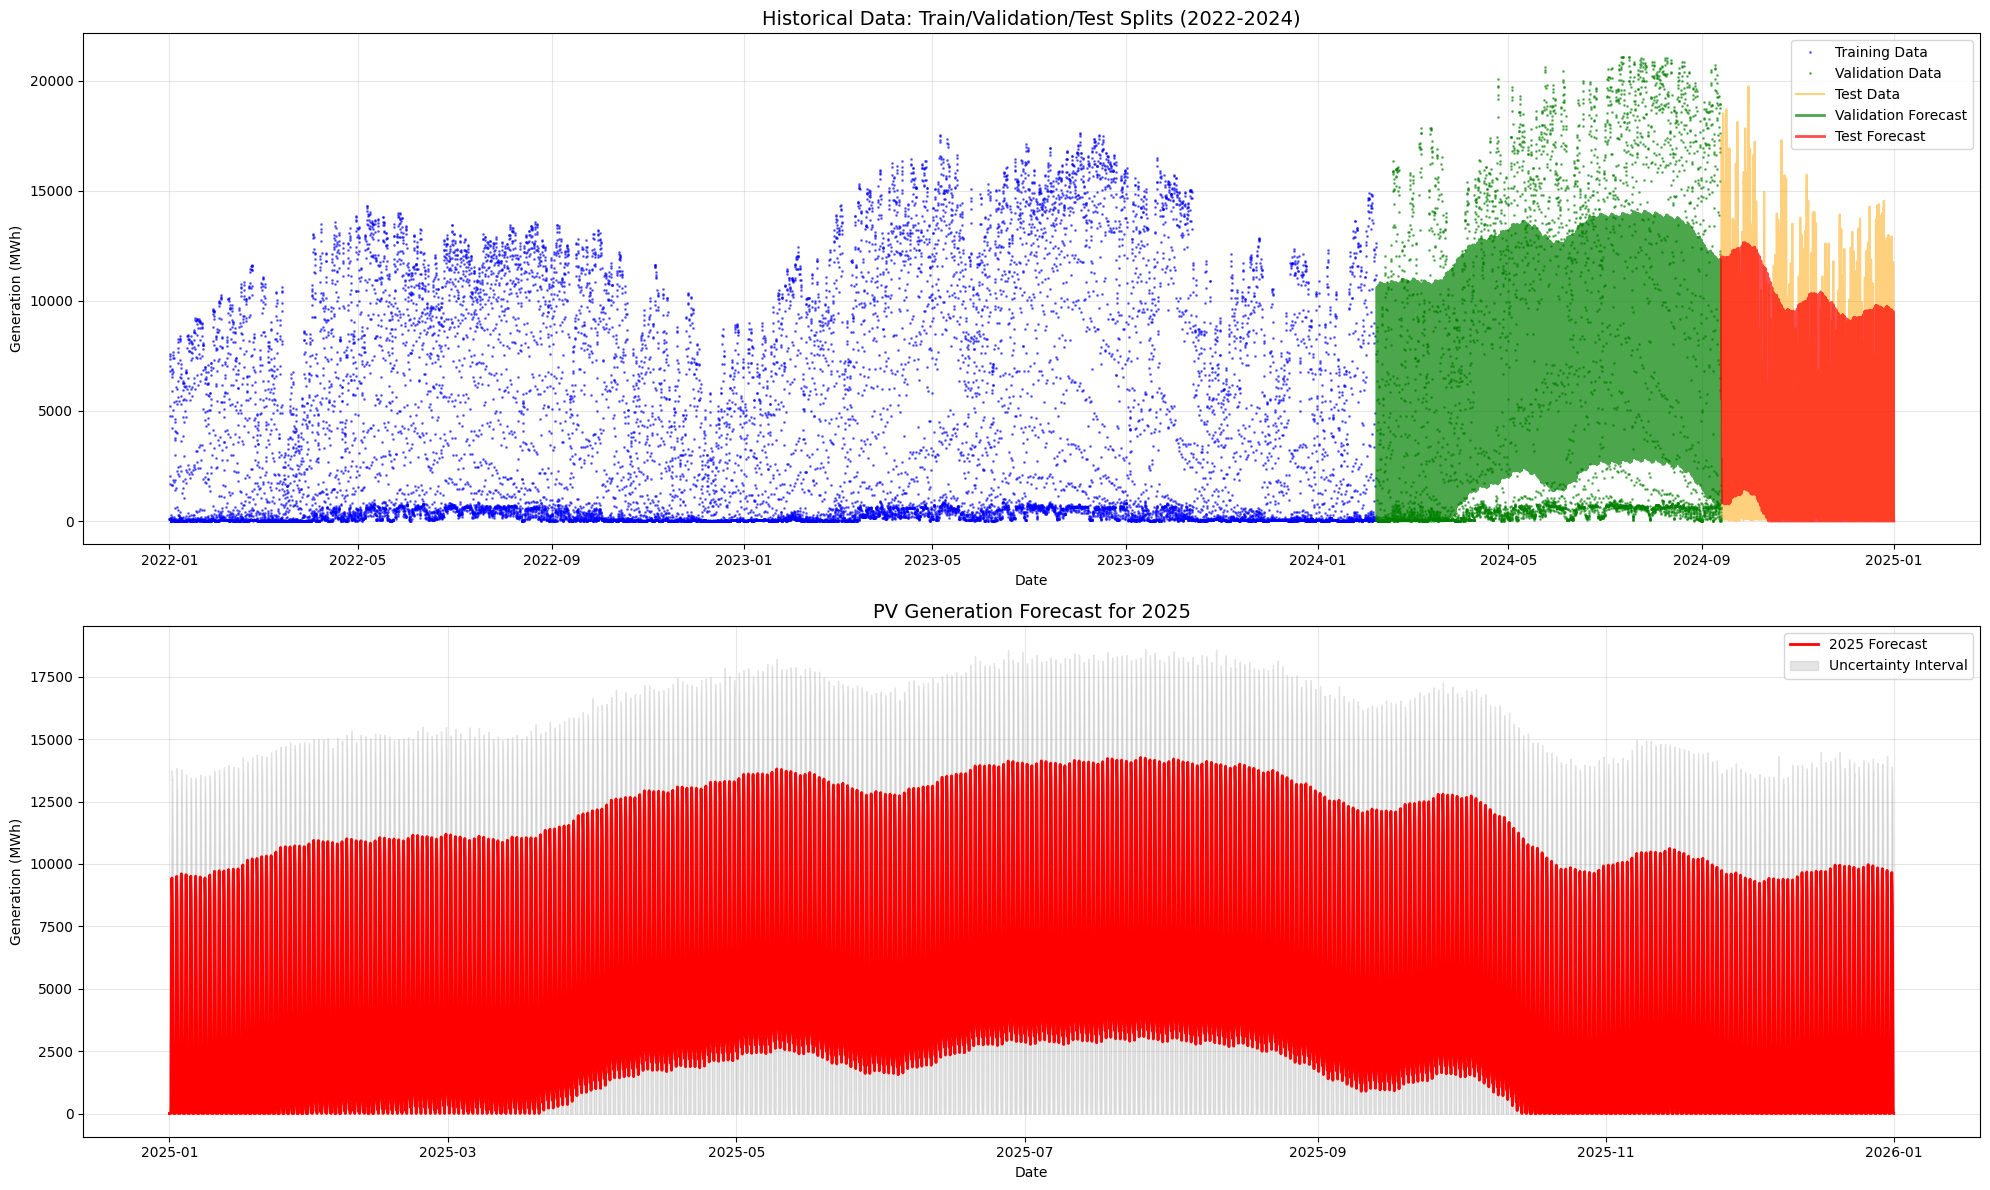

In [11]:
# Visualize train/val/test splits and model performance
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# Plot 1: Historical data with splits
ax1 = axes[0]
ax1.plot(train_df['ds'], train_df['y'], 'b.', label='Training Data', alpha=0.5, markersize=2)
ax1.plot(val_df['ds'], val_df['y'], 'g.', label='Validation Data', alpha=0.5, markersize=2)
ax1.plot(test_df['ds'], test_df['y'], 'orange', label='Test Data', alpha=0.5, markersize=2)

# Add predictions on validation and test sets
ax1.plot(val_forecast['ds'], val_forecast['yhat'], 'g-', label='Validation Forecast', linewidth=2, alpha=0.7)
ax1.plot(test_forecast['ds'], test_forecast['yhat'], 'r-', label='Test Forecast', linewidth=2, alpha=0.7)

ax1.set_title('Historical Data: Train/Validation/Test Splits (2022-2024)', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Generation (MWh)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: 2025 Forecast
ax2 = axes[1]
ax2.plot(forecast_2025['ds'], forecast_2025['yhat'], 'r-', label='2025 Forecast', linewidth=2)
ax2.fill_between(forecast_2025['ds'], 
                 forecast_2025['yhat_lower'], 
                 forecast_2025['yhat_upper'], 
                 color='gray', 
                 alpha=0.2, 
                 label='Uncertainty Interval')

ax2.set_title('PV Generation Forecast for 2025', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Generation (MWh)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

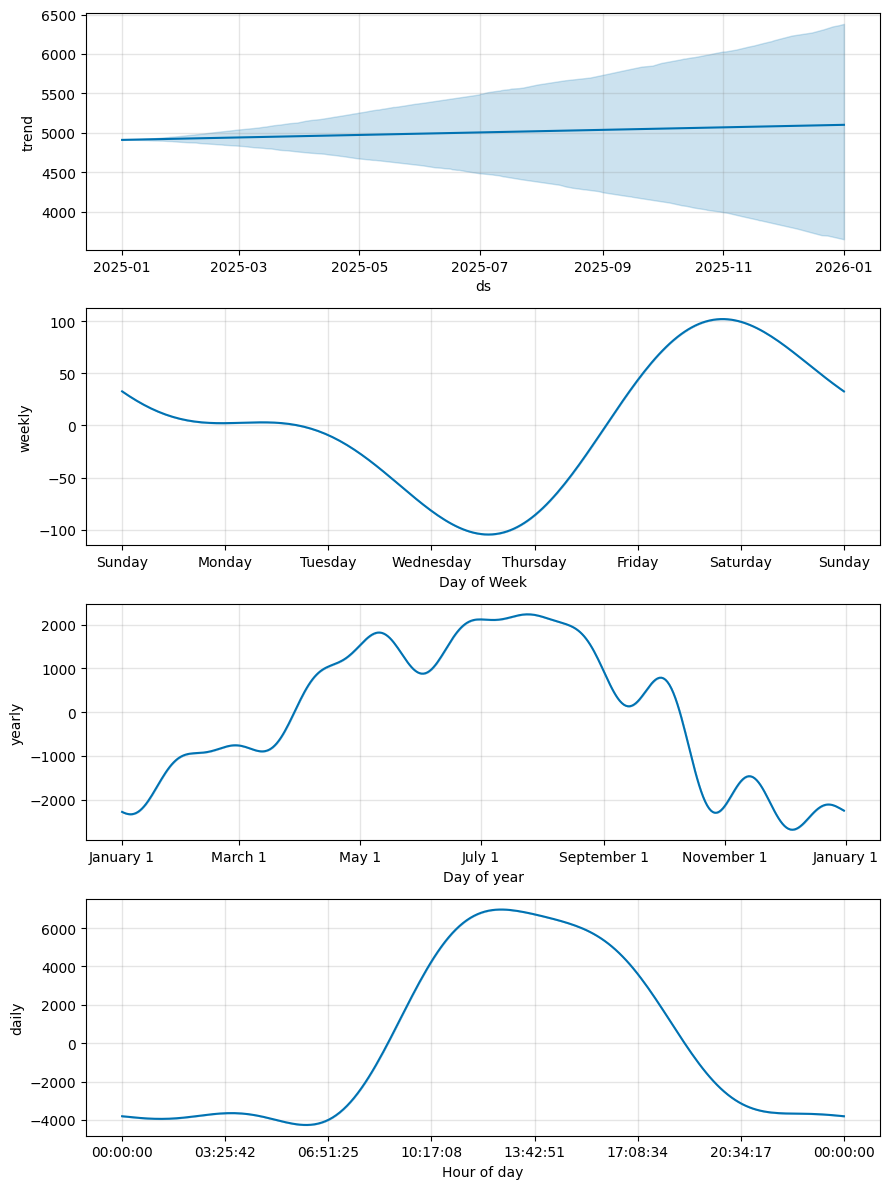

In [12]:
# Show seasonal components
fig = model.plot_components(forecast_2025)
plt.tight_layout()
plt.show()

In [13]:
# Export 2025 forecast to CSV
forecast_export = forecast_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecast_export['timestamp'] = forecast_export['ds'].dt.strftime('%Y-%m-%d %H:%M:%S')
forecast_export = forecast_export[['timestamp', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={
    'timestamp': 'Timestamp',
    'yhat': 'Forecast_Generation_MWh',
    'yhat_lower': 'Forecast_Lower_Bound_MWh',
    'yhat_upper': 'Forecast_Upper_Bound_MWh'
})

output_file = 'pv_forecast_2025_hourly.csv'
forecast_export.to_csv(output_file, index=False)
print(f"2025 forecast exported to: {output_file}")
print(f"\nSummary statistics of 2025 forecast:")
print(forecast_export.describe())

2025 forecast exported to: pv_forecast_2025_hourly.csv

Summary statistics of 2025 forecast:
       Forecast_Generation_MWh  Forecast_Lower_Bound_MWh  \
count              8760.000000               8760.000000   
mean               5112.751087               2392.100499   
std                4438.025149               3237.406977   
min                   0.000000                  0.000000   
25%                1397.701965                  0.000000   
50%                3397.273288                  0.000000   
75%                9341.190549               5172.316955   
max               14267.594632              10327.527985   

       Forecast_Upper_Bound_MWh  
count               8760.000000  
mean                9132.381345  
std                 4563.017527  
min                 2177.792997  
25%                 5499.185363  
50%                 7528.328219  
75%                13450.501868  
max                18611.367031  


In [14]:
# Load actual 2025 data for comparison
df_2025 = pd.read_csv("../Gen_data/actual_PV_2025.csv")
df_2025

,datetime,Area,Production Type,Generation (MWh)
0,2025-01-01 00:00:00,BZN|ES,Solar,4.000000
1,2025-01-01 01:00:00,BZN|ES,Solar,4.000000
2,2025-01-01 02:00:00,BZN|ES,Solar,4.000000
3,2025-01-01 03:00:00,BZN|ES,Solar,4.000000
4,2025-01-01 04:00:00,BZN|ES,Solar,4.000000
...,...,...,...,...
7047,2025-10-21 16:00:00,BZN|ES,Solar,11324.000000
7048,2025-10-21 17:00:00,BZN|ES,Solar,8866.000000
7049,2025-10-21 18:00:00,BZN|ES,Solar,4370.000000
7050,2025-10-21 19:00:00,BZN|ES,Solar,688.000000


In [15]:
# Process 2025 data similar to training data
# The datetime column should already be in the correct format
df_2025['ds'] = pd.to_datetime(df_2025['datetime'])
df_2025['y'] = df_2025['Generation (MWh)']
df_2025 = df_2025[['ds', 'y']].sort_values('ds')

print(f"2025 actual data loaded:")
print(f"  Period: {df_2025['ds'].min()} to {df_2025['ds'].max()}")
print(f"  Total records: {len(df_2025)}")
print(f"  Data range: {df_2025['y'].min():.2f} to {df_2025['y'].max():.2f} MWh")

# Merge forecast with actual 2025 data (both are hourly)
comparison = pd.merge(
    forecast_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], 
    df_2025[['ds', 'y']], 
    on='ds', 
    how='inner'
)

print(f"\nMatched records: {len(comparison)}")

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))

# Calculate MAPE excluding very small values
threshold = 10  # MWh
significant_mask = comparison['y'] >= threshold
if significant_mask.sum() > 0:
    mape = np.mean(np.abs((comparison['y'][significant_mask] - comparison['yhat'][significant_mask]) / comparison['y'][significant_mask])) * 100
else:
    mape = np.nan

print(f"\n2025 Forecast Performance Metrics:")
print("=" * 50)
print(f"MAE:  {mae:.2f} MWh")
print(f"RMSE: {rmse:.2f} MWh")
if not np.isnan(mape):
    print(f"MAPE (generation >= {threshold} MWh): {mape:.2f}%")
else:
    print(f"MAPE: N/A")

# Show data ranges
print(f"\nData ranges:")
print(f"  Actual values: {comparison['y'].min():.2f} to {comparison['y'].max():.2f} MWh")
print(f"  Forecasted values: {comparison['yhat'].min():.2f} to {comparison['yhat'].max():.2f} MWh")

2025 actual data loaded:
  Period: 2025-01-01 00:00:00 to 2025-10-21 20:00:00
  Total records: 7052
  Data range: 0.00 to 23999.00 MWh

Matched records: 7052

2025 Forecast Performance Metrics:
MAE:  2923.42 MWh
RMSE: 3924.91 MWh
MAPE (generation >= 10 MWh): 404.98%

Data ranges:
  Actual values: 0.00 to 23999.00 MWh
  Forecasted values: 0.00 to 14267.59 MWh


In [16]:
# Check for zero values in actual data
zero_counts = (comparison['y'] == 0).sum()
print(f"Number of zero values in actual data: {zero_counts}")

# Calculate metrics with handling for zero values
mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))

# Modified MAPE calculation excluding zero values
non_zero_mask = comparison['y'] != 0
mape = np.mean(np.abs((comparison['y'][non_zero_mask] - comparison['yhat'][non_zero_mask]) / comparison['y'][non_zero_mask])) * 100

print(f"\nMetrics (excluding zero values for MAPE):")
print(f"Mean Absolute Error (MAE): {mae:.2f} MW")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} MW")

# Show min/max values
print(f"\nData ranges:")
print(f"Actual values range: {comparison['y'].min():.2f} to {comparison['y'].max():.2f} MW")
print(f"Forecasted values range: {comparison['yhat'].min():.2f} to {comparison['yhat'].max():.2f} MW")

Number of zero values in actual data: 2

Metrics (excluding zero values for MAPE):
Mean Absolute Error (MAE): 2923.42 MW
Mean Absolute Percentage Error (MAPE): 436.89%
Root Mean Square Error (RMSE): 3924.91 MW

Data ranges:
Actual values range: 0.00 to 23999.00 MW
Forecasted values range: 0.00 to 14267.59 MW


In [17]:
# Add hour of day for filtering daylight hours
comparison['hour'] = comparison['ds'].dt.hour

# Filter for daylight hours (e.g., between 6 AM and 8 PM)
daylight_mask = (comparison['hour'] >= 6) & (comparison['hour'] <= 20)
daylight_data = comparison[daylight_mask]

# Calculate installed capacity (using 95th percentile of actual values as proxy)
installed_capacity = comparison['y'].quantile(0.95)

# Calculate metrics for daylight hours only
daylight_metrics = {
    'MAE (Daylight)': mean_absolute_error(daylight_data['y'], daylight_data['yhat']),
    'RMSE (Daylight)': np.sqrt(mean_squared_error(daylight_data['y'], daylight_data['yhat'])),
    'nMAE': mean_absolute_error(daylight_data['y'], daylight_data['yhat']) / installed_capacity * 100,
    'nRMSE': np.sqrt(mean_squared_error(daylight_data['y'], daylight_data['yhat'])) / installed_capacity * 100
}

# Calculate skill score using persistence model (previous day as forecast)
persistence_forecast = daylight_data['y'].shift(96*4)  # Shift by 1 day (96 15-min intervals)
persistence_mse = mean_squared_error(daylight_data['y'].iloc[96*4:], persistence_forecast.iloc[96*4:])
model_mse = mean_squared_error(daylight_data['y'], daylight_data['yhat'])
skill_score = (1 - model_mse/persistence_mse) * 100

print("Alternative Metrics (Daylight Hours Only):")
print("=======================================")
print(f"Installed Capacity (95th percentile): {installed_capacity:.2f} MW")
print(f"MAE (Daylight): {daylight_metrics['MAE (Daylight)']:.2f} MW")
print(f"RMSE (Daylight): {daylight_metrics['RMSE (Daylight)']:.2f} MW")
print(f"Normalized MAE: {daylight_metrics['nMAE']:.2f}% of installed capacity")
print(f"Normalized RMSE: {daylight_metrics['nRMSE']:.2f}% of installed capacity")
print(f"Forecast Skill Score: {skill_score:.2f}% improvement over persistence model")

Alternative Metrics (Daylight Hours Only):
Installed Capacity (95th percentile): 20082.80 MW
MAE (Daylight): 3806.15 MW
RMSE (Daylight): 4768.94 MW
Normalized MAE: 18.95% of installed capacity
Normalized RMSE: 23.75% of installed capacity
Forecast Skill Score: 83.85% improvement over persistence model


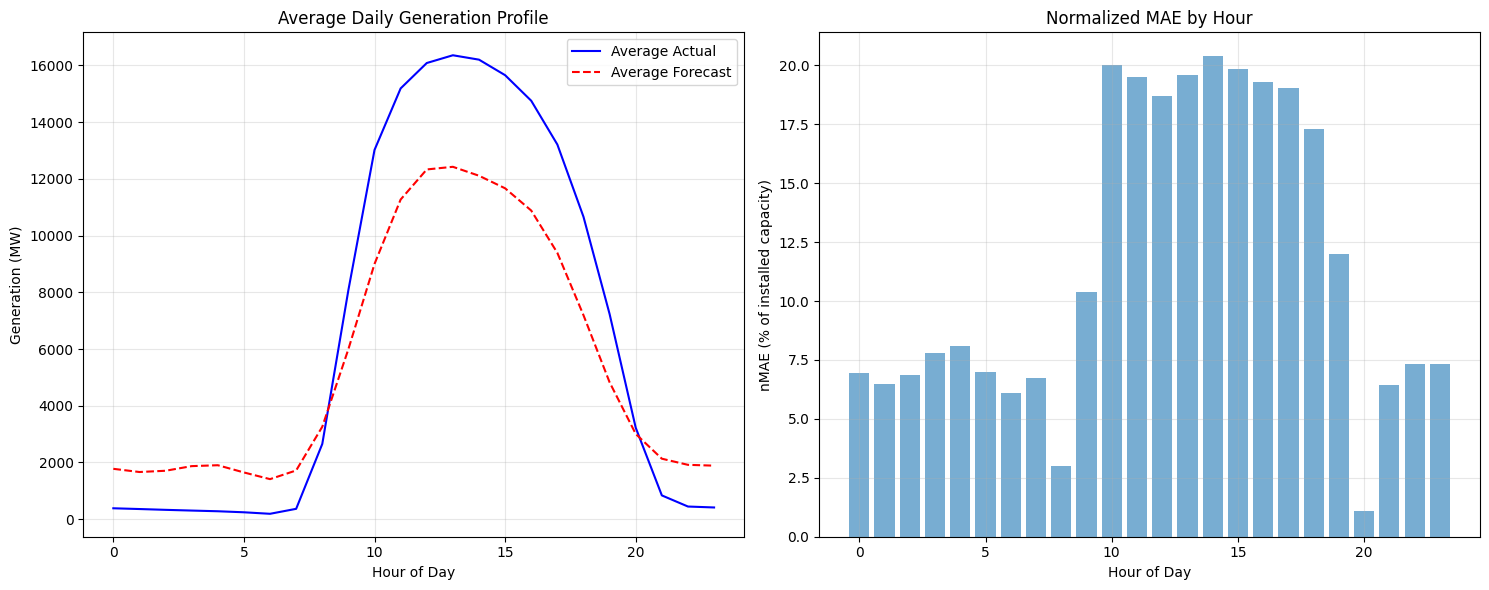

In [18]:
# Create hourly averages for error analysis
hourly_metrics = comparison.groupby('hour').agg({
    'y': 'mean',
    'yhat': 'mean'
}).reset_index()

hourly_metrics['mae'] = abs(hourly_metrics['y'] - hourly_metrics['yhat'])
hourly_metrics['nmae'] = hourly_metrics['mae'] / installed_capacity * 100

# Plot hourly performance
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(hourly_metrics['hour'], hourly_metrics['y'], 'b-', label='Average Actual')
plt.plot(hourly_metrics['hour'], hourly_metrics['yhat'], 'r--', label='Average Forecast')
plt.title('Average Daily Generation Profile')
plt.xlabel('Hour of Day')
plt.ylabel('Generation (MW)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(hourly_metrics['hour'], hourly_metrics['nmae'], alpha=0.6)
plt.title('Normalized MAE by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('nMAE (% of installed capacity)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

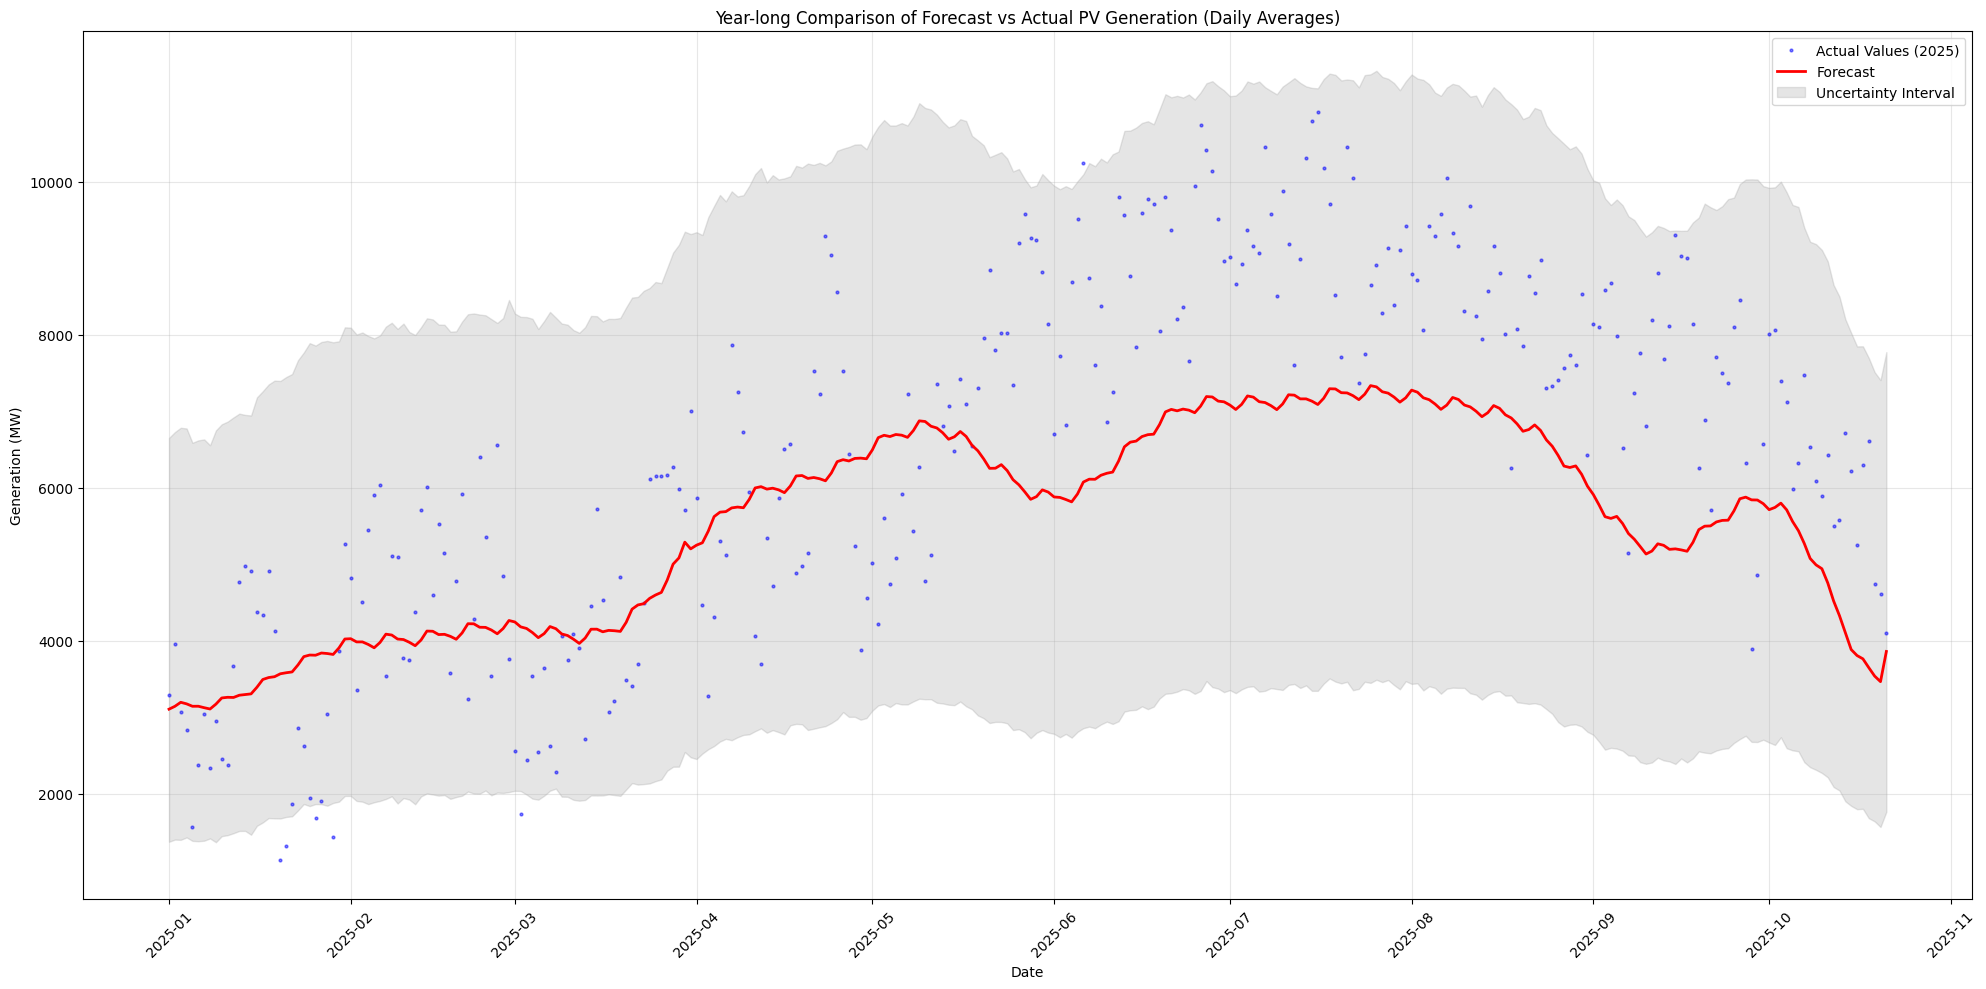


Monthly Performance Metrics:
January 2025:
  Average Actual: 3075.01 MW
  Average Forecast: 3458.07 MW
  MAE: 1502.19 MW
  MAPE: 387.47%
  R²: 0.7287
  nRMSE: 12.26%
---------------------------
February 2025:
  Average Actual: 4820.84 MW
  Average Forecast: 4072.10 MW
  MAE: 1806.32 MW
  MAPE: 385.03%
  R²: 0.7990
  nRMSE: 14.28%
---------------------------
March 2025:
  Average Actual: 4203.84 MW
  Average Forecast: 4351.30 MW
  MAE: 1511.16 MW
  MAPE: 439.32%
  R²: 0.8214
  nRMSE: 10.99%
---------------------------
April 2025:
  Average Actual: 5906.32 MW
  Average Forecast: 5970.46 MW
  MAE: 2459.43 MW
  MAPE: 780.36%
  R²: 0.7679
  nRMSE: 15.50%
---------------------------
May 2025:
  Average Actual: 7022.17 MW
  Average Forecast: 6458.68 MW
  MAE: 2873.67 MW
  MAPE: 415.55%
  R²: 0.7200
  nRMSE: 17.73%
---------------------------
June 2025:
  Average Actual: 8821.97 MW
  Average Forecast: 6563.19 MW
  MAE: 4230.55 MW
  MAPE: 436.16%
  R²: 0.6405
  nRMSE: 25.28%
------------------

In [19]:
# Plot comparison between forecast and actual values
plt.figure(figsize=(20, 10))

# Create daily averages for better visualization
daily_comparison = comparison.set_index('ds').resample('D').mean().reset_index()

# Plot daily averages
plt.plot(daily_comparison['ds'], daily_comparison['y'], 'b.', label='Actual Values (2025)', alpha=0.5, markersize=4)
plt.plot(daily_comparison['ds'], daily_comparison['yhat'], 'r-', label='Forecast', linewidth=2)

# Plot uncertainty intervals
plt.fill_between(daily_comparison['ds'], 
                daily_comparison['yhat_lower'], 
                daily_comparison['yhat_upper'], 
                color='gray', 
                alpha=0.2, 
                label='Uncertainty Interval')

plt.title("Year-long Comparison of Forecast vs Actual PV Generation (Daily Averages)")
plt.xlabel("Date")
plt.ylabel("Generation (MW)")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Add monthly statistics
from sklearn.metrics import r2_score

# Calculate R^2 and nRMSE for each month
print("\nMonthly Performance Metrics:")
print("===========================")

# Get unique months from the comparison data
comparison['year_month'] = comparison['ds'].dt.to_period('M')
unique_months = comparison['year_month'].unique()

for month_period in unique_months:
    # Filter data for this specific month
    month_mask = comparison['year_month'] == month_period
    month_data = comparison[month_mask]
    
    # Skip months with insufficient data
    if len(month_data) < 2:
        print(f"{month_period.strftime('%B %Y')}: No data available")
        print("---------------------------")
        continue
    
    # Calculate metrics
    actual = month_data['y'].values
    predicted = month_data['yhat'].values
    
    # Calculate MAE
    mae = mean_absolute_error(actual, predicted)
    
    # Calculate MAPE (excluding zero values)
    non_zero_mask = actual > 0
    if non_zero_mask.sum() > 0:
        mape = np.mean(np.abs((actual[non_zero_mask] - predicted[non_zero_mask]) / actual[non_zero_mask])) * 100
    else:
        mape = np.nan
    
    # Calculate R^2
    r2 = r2_score(actual, predicted)
    
    # Calculate nRMSE (normalized by installed capacity)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    nrmse = (rmse / installed_capacity) * 100
    
    print(f"{month_period.strftime('%B %Y')}:")
    print(f"  Average Actual: {actual.mean():.2f} MW")
    print(f"  Average Forecast: {predicted.mean():.2f} MW")
    print(f"  MAE: {mae:.2f} MW")
    if np.isnan(mape):
        print("  MAPE: N/A (zero values in actual data)")
    else:
        print(f"  MAPE: {mape:.2f}%")
    print(f"  R²: {r2:.4f}")
    print(f"  nRMSE: {nrmse:.2f}%")
    print("---------------------------")


In [20]:
# Export comparison data to CSV
export_data = comparison.copy()

# Add the hour information (if not already present)
if 'hour' not in export_data.columns:
    export_data['hour'] = export_data['ds'].dt.hour

# Convert datetime to string for better CSV readability
export_data['timestamp'] = export_data['ds'].dt.strftime('%Y-%m-%d %H:%M')

# Select and rename columns for clarity
export_data = export_data[[
    'timestamp', 
    'hour',
    'y', 
    'yhat', 
    'yhat_lower', 
    'yhat_upper'
]].rename(columns={
    'timestamp': 'Timestamp',
    'hour': 'Hour',
    'y': 'Actual_Generation_MWh',
    'yhat': 'Forecast_Generation_MWh',
    'yhat_lower': 'Forecast_Lower_Bound_MWh',
    'yhat_upper': 'Forecast_Upper_Bound_MWh'
})

# Export to CSV
output_path = 'pv_forecast_1-10_comparison_2025.csv'
export_data.to_csv(output_path, index=False)
print(f"Data exported to: {output_path}")
print(f"Total records exported: {len(export_data)}")
print("\nFirst few rows of exported data:")
print(export_data.head(20).to_string())

Data exported to: pv_forecast_1-10_comparison_2025.csv
Total records exported: 7052

First few rows of exported data:
           Timestamp  Hour  Actual_Generation_MWh  Forecast_Generation_MWh  Forecast_Lower_Bound_MWh  Forecast_Upper_Bound_MWh
0   2025-01-01 00:00     0                    4.0                 0.000000                  0.000000               2875.029697
1   2025-01-01 01:00     1                    4.0                 0.000000                  0.000000               2688.299118
2   2025-01-01 02:00     2                    4.0                 0.000000                  0.000000               2945.255058
3   2025-01-01 03:00     3                    4.0                 0.000000                  0.000000               2913.894083
4   2025-01-01 04:00     4                    4.0                 0.000000                  0.000000               3459.064058
5   2025-01-01 05:00     5                    4.0                 0.000000                  0.000000               2773.

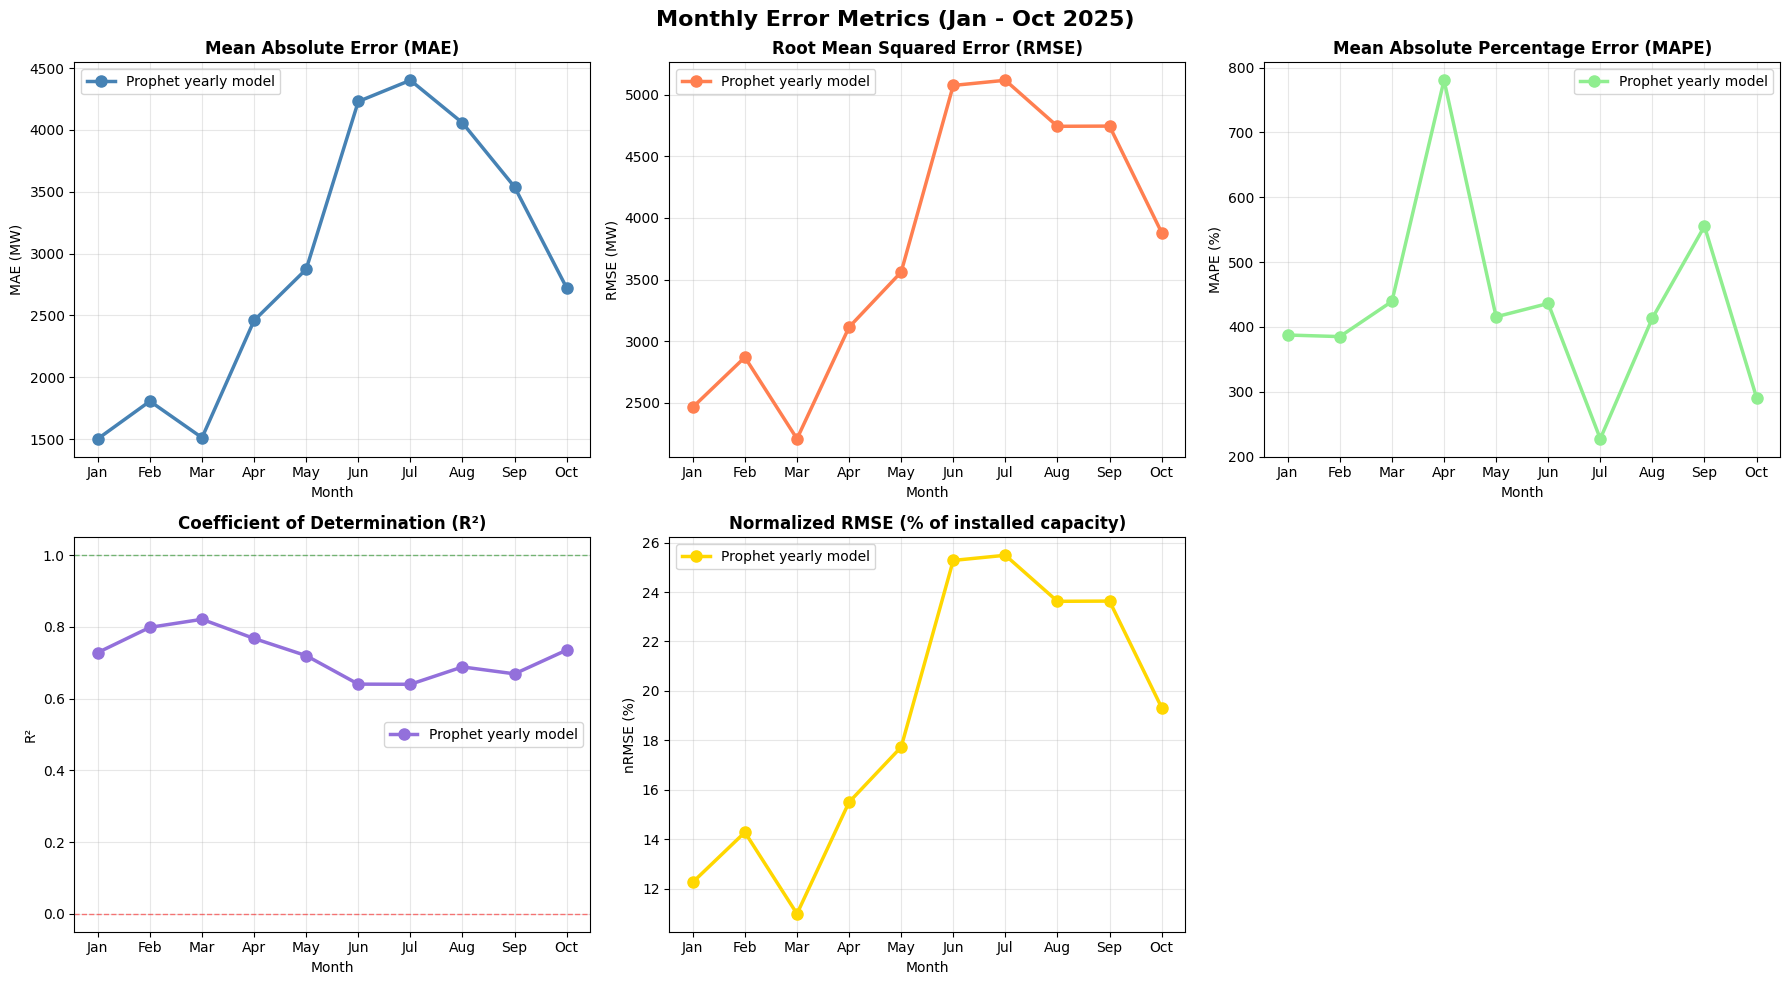


Monthly Error Metrics Summary Table:
Month         MAE        RMSE       MAPE       R²     nRMSE
  Jan 1502.185856 2463.065349 387.465087 0.728719 12.264551
  Feb 1806.315948 2868.528050 385.027595 0.798976 14.283507
  Mar 1511.164500 2206.290436 439.321087 0.821400 10.985970
  Apr 2459.431288 3113.087517 780.364130 0.767872 15.501262
  May 2873.670808 3560.436065 415.548654 0.719975 17.728783
  Jun 4230.545206 5076.623938 436.155981 0.640541 25.278467
  Jul 4402.338011 5118.618898 227.422513 0.640143 25.487576
  Aug 4057.633271 4744.555885 413.569024 0.688540 23.624972
  Sep 3539.543819 4746.315211 555.216325 0.669253 23.633732
  Oct 2723.022996 3881.964558 290.890427 0.735586 19.329797

Overall Statistics:
  Best R² Month: Mar (0.8214)
  Worst R² Month: Jul (0.6401)
  Lowest MAE Month: Jan (1502.19 MW)
  Highest MAE Month: Jul (4402.34 MW)


In [21]:
# Create monthly error metrics visualization
from sklearn.metrics import r2_score

# Get unique months from the comparison data
comparison['year_month'] = comparison['ds'].dt.to_period('M')
unique_months = sorted(comparison['year_month'].unique())

# Store metrics for each month
monthly_metrics_data = []

for month_period in unique_months:
    # Filter data for this specific month
    month_mask = comparison['year_month'] == month_period
    month_data = comparison[month_mask]
    
    # Skip months with insufficient data
    if len(month_data) < 2:
        continue
    
    # Calculate metrics
    actual = month_data['y'].values
    predicted = month_data['yhat'].values
    
    # Calculate all metrics
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    # MAPE (excluding zero values)
    non_zero_mask = actual > 0
    if non_zero_mask.sum() > 0:
        mape = np.mean(np.abs((actual[non_zero_mask] - predicted[non_zero_mask]) / actual[non_zero_mask])) * 100
    else:
        mape = np.nan
    
    # R²
    r2 = r2_score(actual, predicted)
    
    # nRMSE (normalized by installed capacity)
    nrmse = (rmse / installed_capacity) * 100
    
    monthly_metrics_data.append({
        'Month': month_period.strftime('%b'),
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2,
        'nRMSE': nrmse
    })

# Create DataFrame for easier plotting
metrics_df = pd.DataFrame(monthly_metrics_data)

# Create subplots for each metric (2x3 layout, reduced to 5 plots)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Monthly Error Metrics (Jan - Oct 2025)', fontsize=16, fontweight='bold')

# Plot 1: MAE
ax1 = axes[0, 0]
ax1.plot(metrics_df['Month'], metrics_df['MAE'], marker='o', color='steelblue', 
         linewidth=2.5, markersize=8, label='Prophet yearly model')
ax1.set_title('Mean Absolute Error (MAE)', fontweight='bold')
ax1.set_ylabel('MAE (MW)')
ax1.set_xlabel('Month')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best')

# Plot 2: RMSE
ax2 = axes[0, 1]
ax2.plot(metrics_df['Month'], metrics_df['RMSE'], marker='o', color='coral', 
         linewidth=2.5, markersize=8, label='Prophet yearly model')
ax2.set_title('Root Mean Squared Error (RMSE)', fontweight='bold')
ax2.set_ylabel('RMSE (MW)')
ax2.set_xlabel('Month')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')

# Plot 3: MAPE
ax3 = axes[0, 2]
ax3.plot(metrics_df['Month'], metrics_df['MAPE'], marker='o', color='lightgreen', 
         linewidth=2.5, markersize=8, label='Prophet yearly model')
ax3.set_title('Mean Absolute Percentage Error (MAPE)', fontweight='bold')
ax3.set_ylabel('MAPE (%)')
ax3.set_xlabel('Month')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='best')

# Plot 4: R²
ax4 = axes[1, 0]
ax4.plot(metrics_df['Month'], metrics_df['R²'], marker='o', color='mediumpurple', 
         linewidth=2.5, markersize=8, label='Prophet yearly model')
ax4.set_title('Coefficient of Determination (R²)', fontweight='bold')
ax4.set_ylabel('R²')
ax4.set_xlabel('Month')
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
ax4.axhline(y=1, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax4.grid(True, alpha=0.3)
ax4.legend(loc='best')

# Plot 5: nRMSE
ax5 = axes[1, 1]
ax5.plot(metrics_df['Month'], metrics_df['nRMSE'], marker='o', color='gold', 
         linewidth=2.5, markersize=8, label='Prophet yearly model')
ax5.set_title('Normalized RMSE (% of installed capacity)', fontweight='bold')
ax5.set_ylabel('nRMSE (%)')
ax5.set_xlabel('Month')
ax5.grid(True, alpha=0.3)
ax5.legend(loc='best')

# Hide the unused subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Print summary table
print("\nMonthly Error Metrics Summary Table:")
print("=" * 80)
print(metrics_df.to_string(index=False))
print("=" * 80)
print(f"\nOverall Statistics:")
print(f"  Best R² Month: {metrics_df.loc[metrics_df['R²'].idxmax(), 'Month']} ({metrics_df['R²'].max():.4f})")
print(f"  Worst R² Month: {metrics_df.loc[metrics_df['R²'].idxmin(), 'Month']} ({metrics_df['R²'].min():.4f})")
print(f"  Lowest MAE Month: {metrics_df.loc[metrics_df['MAE'].idxmin(), 'Month']} ({metrics_df['MAE'].min():.2f} MW)")
print(f"  Highest MAE Month: {metrics_df.loc[metrics_df['MAE'].idxmax(), 'Month']} ({metrics_df['MAE'].max():.2f} MW)")


In [22]:
metrics_df.to_csv('pv_metrics_yearly.csv')
metrics_df

,Month,MAE,RMSE,MAPE,R²,nRMSE
0,Jan,1502.185856,2463.065349,387.465087,0.728719,12.264551
1,Feb,1806.315948,2868.528050,385.027595,0.798976,14.283507
2,Mar,1511.164500,2206.290436,439.321087,0.821400,10.985970
3,Apr,2459.431288,3113.087517,780.364130,0.767872,15.501262
4,May,2873.670808,3560.436065,415.548654,0.719975,17.728783
5,Jun,4230.545206,5076.623938,436.155981,0.640541,25.278467
6,Jul,4402.338011,5118.618898,227.422513,0.640143,25.487576
7,Aug,4057.633271,4744.555885,413.569024,0.688540,23.624972
8,Sep,3539.543819,4746.315211,555.216325,0.669253,23.633732
9,Oct,2723.022996,3881.964558,290.890427,0.735586,19.329797
